# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [91]:
import numpy as np
import pandas as pd
import itertools
# TODO: Agregar las librerías que hagan falta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#funcion plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta correcta')
    plt.xlabel('Etiqueta predicha')

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [92]:
#dataset = pd.read_csv("./data/loan_data.csv", comment="#")
url = 'https://drive.google.com/file/d/1BHWUzbBnrBX8PsF9Sqb80Gq96eyqbQtb/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
dataset = pd.read_csv(dwn_url, comment="#")
dataset[:3]

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012


In [93]:
# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dataset.keys()

Index(['TARGET', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**


### **1.** ¿De qué se trata el conjunto de datos?

El conjunto de datos muestra informacion de referencia y de desempeño de credito de solicitantes recientes de un banco a los cuales se les otorgaron lineas de credito de equidad de vivienda siguiendo las recomendaciones de la Ley de Creditos de Equidad de Vivienda.

- Traata sobre el **V**alor **A**cumulado de la **V**ivienda (HMEQ, por sus siglas en inglés) y contiene información de referencia y rendimiento de 5960 préstamos recientes con garantía hipotecaria. 

- El target es una variable binaria que indica si un solicitante finalmente incumplió o fue gravemente delincuente. Este resultado adverso ocurrió en 1189 casos (20%). Para cada solicitante se registraron 12 variables de entrada.

El contexto en el cual se uso el dataset es el siguiente: 
- El departamento de crédito al consumo de un banco quiere automatizar el proceso de toma de decisiones para la aprobación de líneas de crédito con garantía hipotecaria. Para ello harán seguir las recomendaciones de la Ley de Igualdad de Oportunidades de Crédito para crear un modelo de calificación crediticia empíricamente derivado y estadísticamente sólido. 
- El modelo se basará en datos recopilados de solicitantes recientes a los que se les otorgó crédito a través de el proceso actual de suscripción de préstamos. El modelo se construirá a partir de herramientas de modelado predictivo, pero el modelo creado debe ser lo suficientemente interpretable para proporcionar una razón para cualquier acción adversa (rechazos).


###**2.** ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?

La variable objetivo que hay que predecir es **TARGET/BAD**, la misma es una variable binaria que indica:
- 1 = El cliente incumplio o delinquio gravemente con el prestamo
- 0 = El prestamo fue reembolsado correspondientemente

###**3.** ¿Qué información (atributos) hay disponible para hacer la predicción?

In [94]:
X.columns

Index(['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC'],
      dtype='object')

 *  `LOAN` Importe de la solicitud de préstamo
 * `MORTDUE` Cantidad adeudada en la hipoteca existente $^1$
 * `VALUE`   Valor actual de la propiedad
 * `YOJ`     Años en el trabajo actual
 * `DEROG`   Numero de informes derogatorios importantes
 * `DELINQ`  Numero de lineas de credito morosas
 * `CLAGE`   Edad de la  Trade Line$^2$ mas antigua en meses
 * `NINQ`    Numero de lineas de credito recientes
 * `CLNO`    Number de lineas de credito actuales
 * `DEBTINC` Relacion deuda sobre ingresos o indice de endeudamiento

$^1$ [*MORTDUE*]( https://www.kaggle.com/datasets/ajay1735/hmeq-data/discussion/1226792)   
$^2$ [*TRADE LINE*](https://www.investopedia.com/terms/t/trade-line.asp)


###**4.** ¿Qué atributos imagina ud. que son los más determinantes para la predicción?



Consideramos que los atributos mas determinantes para la prediccion son `DEBTINC`, `VALUE`, `NINQ`, `CLNO` y `DELINQ`. Estimamos que `MORTDDUE` al ser un valor relativo al valor que se paga de la propiedad tambien va a ser representativo aunque no comprendemos muy bien que implica el valor de equidad dado en funcion del valor de la propiedad y la garantia hipotecaria.

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

- La **precision** es la proporción de positivos propuestos por el modelo que fueron correctos:

$$Precision = \frac{|Train \cap Test|}{|Train|} = \frac{TP}{TP + FP}$$

El mejor valor es 1 y el peor valor es 0. 

-  La **recall** es la proporción de positivos correctos que fueron encontrados por el modelo:

$$Recall = \frac{|Train \cap Test|}{|Test|} = \frac{TP}{TP + FN}$$

-  El valor **F1** se utiliza para combinar las medidas de precision y recall en un sólo valor.
$$F_1 = \frac{2 * Precision * Recall}{Precision + Recall}$$

Para clasificación multiclase, se puede calcular una métrica por clase. Luego, las métricas se pueden promediar para obtener resultados "macro".
Para obtener resultados "micro", se hacen primero cálculos globales para TP, FP, TN, FN y luego se calcula como un problema binario.

In [95]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [96]:
def print_metrics(y,yprecit):
  print(f'Accuracy: {round(accuracy_score(y,yprecit),4)}')
  print(f'Precision: {round(precision_score(y, yprecit),4)}')
  print(f'Recall: {round(recall_score(y, yprecit),4)}') 
  print(f'F1 score: {round(f1_score(y,yprecit),4)}')
  plot_confusion_matrix(confusion_matrix(y, yprecit),['0-reembolso','1-incumplió'])

La matriz se comporta de la siguiente manera

TN | FP  
FN | TP  

Ya que considera 0 como clase negativa y 1 como clase positiva. sklearn siempre considera el número más pequeño como negativo y el número grande como positivo.

La precisión será la suma de los elementos de la diagonal dividida por la suma de todos los elementos.p Los elementos de la diagonal son el número de predicciones correctas.

### Datos Entrenamiento

In [97]:
#entrenamiento
sgd_clf = SGDClassifier(random_state=123)
sgd_clf.fit(X_train, y_train)
print(cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring="accuracy"))
#prediccion
y_train_pred_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv=5)

[0.81481481 0.83501684 0.83501684 0.83783784 0.83783784]


Accuracy: 0.8321
Precision: 0.0
Recall: 0.0
F1 score: 0.0


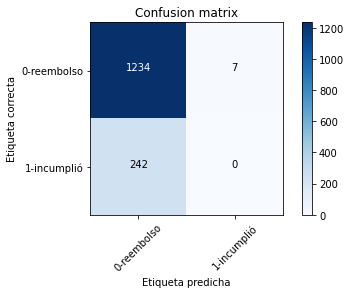

In [98]:
print_metrics(y_train,y_train_pred_sgd)

Vemos que el modelo al incio clasifica la gran mayoria como reembolsados, que por eso el Accuracy da alto, pero no asi las otras metricas

### Datos Validacion

In [99]:
sgd_clf.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Vemos que el clasificador aprendio a clasificar todo como negativo, es decir como rembolso, por ende clasifica mal.

Para ver si podemos cambiar las clasificaciones predecimos con la validacion cruzada.

In [100]:
cross_val_score(sgd_clf, X_test, y_test, cv=5, scoring="accuracy")

array([0.28      , 0.17567568, 0.82432432, 0.17567568, 0.81081081])

In [101]:
y_test_pred_sgd = cross_val_predict(sgd_clf, X_test, y_test, cv=5)

Accuracy: 0.4528
Precision: 0.1822
Recall: 0.5821
F1 score: 0.2776


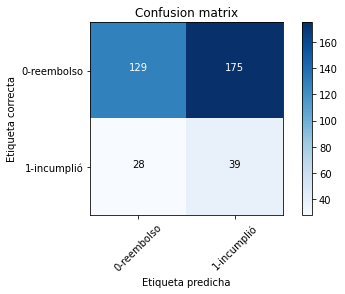

In [102]:
print_metrics(y_test,y_test_pred_sgd)

Vemos que el modelo al incio clasifica un poco mejor la gran mayoria como reembolsados, que por eso el Accuracy da alto, pero no asi las otras metricas

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

### Ajuste de hiperparametros

In [103]:
from sklearn.model_selection import GridSearchCV

param_grid_sgd = [{
    'loss':['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': np.linspace(0.01, 0.05, 10),
    'learning_rate' : ['optimal', 'constant', 'invscaling','adaptive'],
    'eta0': np.linspace(0.01, 0.05, 10)
}]

grid_search_sgd = GridSearchCV(sgd_clf, param_grid_sgd, cv=5, scoring="accuracy")

grid_search_sgd.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
6000 fits failed out of a total of 30000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6000 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 892, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 649, in _fit
    self._validate_params()
  File "/usr/local/lib/pyth

GridSearchCV(cv=5, estimator=SGDClassifier(random_state=123),
             param_grid=[{'alpha': array([0.01      , 0.01444444, 0.01888889, 0.02333333, 0.02777778,
       0.03222222, 0.03666667, 0.04111111, 0.04555556, 0.05      ]),
                          'eta0': array([0.01      , 0.01444444, 0.01888889, 0.02333333, 0.02777778,
       0.03222222, 0.03666667, 0.04111111, 0.04555556, 0.05      ]),
                          'learning_rate': ['optimal', 'constant', 'invscaling',
                                            'adaptive'],
                          'loss': ['hinge', 'log_loss', 'modified_huber',
                                   'squared_hinge', 'perceptron'],
                          'penalty': ['l2', 'l1', 'elasticnet']}],
             scoring='accuracy')

In [104]:
results_df = pd.DataFrame(grid_search_sgd.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
0.03222222222222222_0.04111111111111111_adaptive_hinge_elasticnet,"{'alpha': 0.03222222222222222, 'eta0': 0.04111...",1,0.838846,0.009284
0.01888888888888889_0.02333333333333333_constant_modified_huber_elasticnet,"{'alpha': 0.01888888888888889, 'eta0': 0.02333...",2,0.838170,0.003502
0.03666666666666667_0.01888888888888889_optimal_modified_huber_elasticnet,"{'alpha': 0.03666666666666667, 'eta0': 0.01888...",2,0.838170,0.003502
0.03666666666666667_0.02333333333333333_optimal_modified_huber_elasticnet,"{'alpha': 0.03666666666666667, 'eta0': 0.02333...",2,0.838170,0.003502
0.03666666666666667_0.027777777777777776_optimal_modified_huber_elasticnet,"{'alpha': 0.03666666666666667, 'eta0': 0.02777...",2,0.838170,0.003502
...,...,...,...,...
0.01888888888888889_0.03222222222222222_adaptive_log_loss_l2,"{'alpha': 0.01888888888888889, 'eta0': 0.03222...",5996,NaN,NaN
0.014444444444444444_0.01_adaptive_log_loss_l1,"{'alpha': 0.014444444444444444, 'eta0': 0.01, ...",5997,NaN,NaN
0.014444444444444444_0.01_adaptive_log_loss_elasticnet,"{'alpha': 0.014444444444444444, 'eta0': 0.01, ...",5998,NaN,NaN


In [105]:
grid_search_sgd.best_params_

{'alpha': 0.03222222222222222,
 'eta0': 0.04111111111111111,
 'learning_rate': 'adaptive',
 'loss': 'hinge',
 'penalty': 'elasticnet'}

### Entrenamiento

In [106]:
sgd_clf = SGDClassifier(alpha =0.0322222222222, loss='hinge',\
                        penalty = 'elasticnet', learning_rate ='adaptive', eta0 = 0.04111111111111111, random_state=123)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0322222222222, eta0=0.04111111111111111,
              learning_rate='adaptive', penalty='elasticnet', random_state=123)

In [107]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring="accuracy")

array([0.83838384, 0.84848485, 0.82154882, 0.84121622, 0.84459459])

In [108]:
y_train_pred_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv=5)

Accuracy: 0.8388
Precision: 0.5294
Recall: 0.1116
F1 score: 0.1843


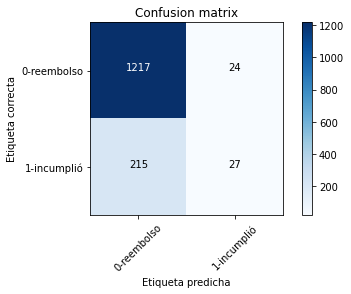

In [109]:
print_metrics(y_train,y_train_pred_sgd)

### Validacion

In [110]:
sgd_clf.predict(X_test)

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [111]:
cross_val_score(sgd_clf, X_test, y_test, cv=5, scoring="accuracy")

array([0.73333333, 0.71621622, 0.83783784, 0.77027027, 0.64864865])

In [112]:
y_test_pred_sgd = cross_val_predict(sgd_clf, X_test, y_test, cv=5)

Accuracy: 0.7412
Precision: 0.2698
Recall: 0.2537
F1 score: 0.2615


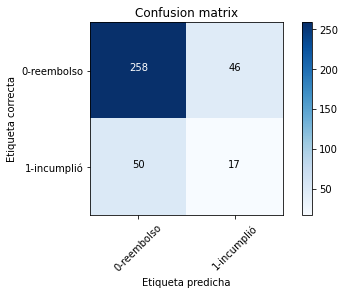

In [113]:
print_metrics(y_test,y_test_pred_sgd)

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


### Entrenamiento

In [114]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=123)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

In [115]:
cross_val_score(tree_clf, X_train, y_train, cv=5, scoring="accuracy")

array([0.88552189, 0.87542088, 0.86195286, 0.89189189, 0.88175676])

In [116]:
y_train_pred_tree = cross_val_predict(tree_clf, X_train, y_train, cv=5)

Accuracy: 0.8793
Precision: 0.6438
Recall: 0.5826
F1 score: 0.6117


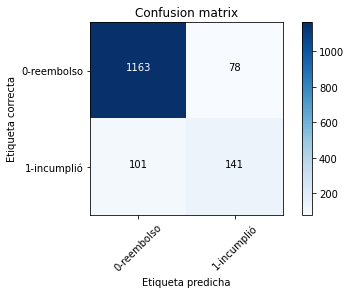

In [117]:
print_metrics(y_train,y_train_pred_tree)

### Validacion

In [118]:
tree_clf.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,

In [119]:
cross_val_score(tree_clf, X_test, y_test, cv=5, scoring="accuracy")

array([0.74666667, 0.7972973 , 0.78378378, 0.83783784, 0.7972973 ])

In [120]:
y_test_pred_tree = cross_val_predict(tree_clf, X_test, y_test, cv=5)


Accuracy: 0.7925
Precision: 0.4107
Recall: 0.3433
F1 score: 0.374


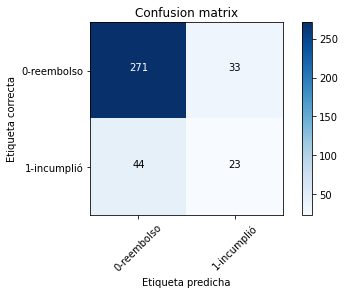

In [121]:
print_metrics(y_test,y_test_pred_tree)

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

### Ajuste de hiperparametros

In [ ]:
param_grid_tree = [{
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10],
}]

grid_search_tree = GridSearchCV(tree_clf, param_grid_tree,scoring="accuracy", cv=5)

grid_search_tree.fit(X_train, y_train)

In [123]:
results_df = pd.DataFrame(grid_search_tree.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
entropy_9_2,"{'criterion': 'entropy', 'max_depth': 9, 'min_...",1,0.896822,0.009774
gini_9_2,"{'criterion': 'gini', 'max_depth': 9, 'min_sam...",2,0.896158,0.018883
gini_10_1,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",3,0.894818,0.013659
gini_9_3,"{'criterion': 'gini', 'max_depth': 9, 'min_sam...",4,0.894811,0.023097
entropy_8_6,"{'criterion': 'entropy', 'max_depth': 8, 'min_...",5,0.894808,0.006526
...,...,...,...,...
log_loss_3_8,"{'criterion': 'log_loss', 'max_depth': 3, 'min...",296,NaN,NaN
log_loss_3_7,"{'criterion': 'log_loss', 'max_depth': 3, 'min...",297,NaN,NaN
log_loss_3_6,"{'criterion': 'log_loss', 'max_depth': 3, 'min...",298,NaN,NaN


In [124]:
grid_search_tree.best_params_

{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 2}

### Entrenamiento

In [125]:
tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=2, random_state=123)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=2,
                       random_state=123)

In [126]:
cross_val_score(tree_clf, X_train, y_train, cv=5, scoring="accuracy")

array([0.8956229 , 0.91245791, 0.8956229 , 0.88175676, 0.89864865])

In [127]:
y_train_pred_tree = cross_val_predict(tree_clf, X_train, y_train, cv=5)

Accuracy: 0.8968
Precision: 0.7697
Recall: 0.5248
F1 score: 0.6241


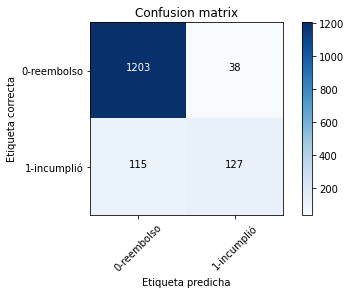

In [128]:
print_metrics(y_train,y_train_pred_tree)

### Validacion

In [129]:
tree_clf.predict(X_test)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [130]:
cross_val_score(tree_clf, X_test, y_test, cv=5, scoring="accuracy")

array([0.76      , 0.82432432, 0.81081081, 0.78378378, 0.85135135])

In [131]:
y_test_pred_tree = cross_val_predict(tree_clf, X_test, y_test, cv=5)

Accuracy: 0.8059
Precision: 0.4528
Recall: 0.3582
F1 score: 0.4


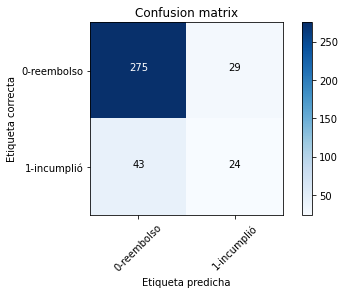

In [132]:
print_metrics(y_test,y_test_pred_tree)